In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Polinom regresyon modeli ile özellikleri verilen evlerin fiyat tahminini yapacağız.
df = pd.read_excel("satılık_ev.xlsx")
df.head(3)

,Unnamed: 0,Fiyat,Oda_Sayısı,Net_m2,Katı,Yaşı
0,0,475,1,40,0,6
1,1,475,1,55,0,5
2,2,450,1,50,0,7


In [3]:
# Unnamed: 0 sütununu veriden çıkartıyoruz.
df = df.drop("Unnamed: 0", axis=1)
df.head(1)

,Fiyat,Oda_Sayısı,Net_m2,Katı,Yaşı
0,475,1,40,0,6


In [4]:
# Veri hakında
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Fiyat       191 non-null    int64
 1   Oda_Sayısı  191 non-null    int64
 2   Net_m2      191 non-null    int64
 3   Katı        191 non-null    int64
 4   Yaşı        191 non-null    int64
dtypes: int64(5)
memory usage: 7.6 KB


In [5]:
# Eksik veri kontrolu.
df.isnull().sum()

Fiyat         0
Oda_Sayısı    0
Net_m2        0
Katı          0
Yaşı          0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Fiyat,191.0,649.476440,111.064174,450.0,575.0,650.0,700.0,1175.0
Oda_Sayısı,191.0,2.340314,0.721401,1.0,2.0,2.0,3.0,3.0
Net_m2,191.0,85.183246,16.482620,40.0,80.0,90.0,95.0,125.0
Katı,191.0,3.931937,3.752974,0.0,0.0,3.0,7.0,11.0
Yaşı,191.0,12.753927,8.374596,0.0,4.0,16.0,20.0,24.0


In [7]:
# Birbirleriyle korelasyon durumunu inceliyoruz.
df.corr(numeric_only=True)

,Fiyat,Oda_Sayısı,Net_m2,Katı,Yaşı
Fiyat,1.000000,0.672268,0.749723,0.380615,0.038339
Oda_Sayısı,0.672268,1.000000,0.811385,-0.084711,0.614175
Net_m2,0.749723,0.811385,1.000000,0.156756,0.201650
Katı,0.380615,-0.084711,0.156756,1.000000,-0.460209
Yaşı,0.038339,0.614175,0.201650,-0.460209,1.000000


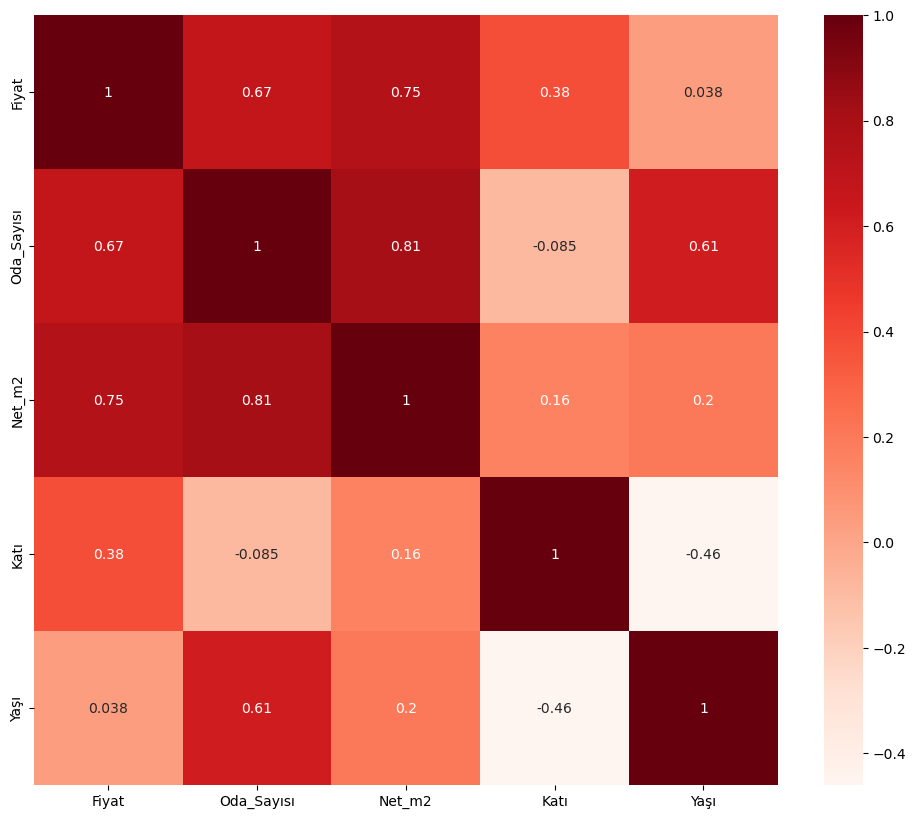

In [8]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show;

* Daire fiyatının oda sayısı ve m2 ile yüksek korelasyonlu olduğunu, binanın yaşı ile düşük korelasyonlu olduğunu söyleyebiliriz.

In [9]:
# Hedef değişken ve bağımsız değişkenleri belirliyorum.
X = df.drop("Fiyat", axis=1)
y = df["Fiyat"]

# Veri setini, eğitim ve test verisi olarak ayırıyorum.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (152, 4)
x_test shape: (39, 4)
y_train shape: (152,)
y_test shape: (39,)


In [10]:
# Hedef değişken ile 0.5 den yüksek korelasyona sahip bağımsız değişkenleri tekrar görelim.
cor = pd.concat([y_train, X_train], axis=1).corr(method="pearson")
cor_target = abs(cor["Fiyat"])
relevant_features = cor_target[cor_target > 0.5]
relevant_features

Fiyat         1.000000
Oda_Sayısı    0.675721
Net_m2        0.769196
Name: Fiyat, dtype: float64

In [11]:
from sklearn.preprocessing import PolynomialFeatures

In [12]:
# Öznitelik değişkenlerinin polinom derecelerini oluşturup her bir polinom derecesi ile oluşturulan modelin hata skorunu hesaplatıyoruz.
# Hata skorunu RMSE'ü kulanıyoruz.
rmses = []
degrees = np.arange(1,10);
min_rmse, min_deg = 1e10, 0

for deg in degrees:
    # Eğitim seti öznitelikleri
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_train= poly_features.fit_transform(X_train)
    # Doğrusal regresyon
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    # Test seti ile karşılaştırılması
    X_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(X_poly_test)
    poly_mse = mean_absolute_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    # Çapraz doğrulama ile polinom derecesi
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

print("En iyi model {} RMSE hata skoru veren, {} polinom dercesi ile sağlanıyor".format(min_rmse,min_deg))

En iyi model 6.373221036575792 RMSE hata skoru veren, 2 polinom dercesi ile sağlanıyor


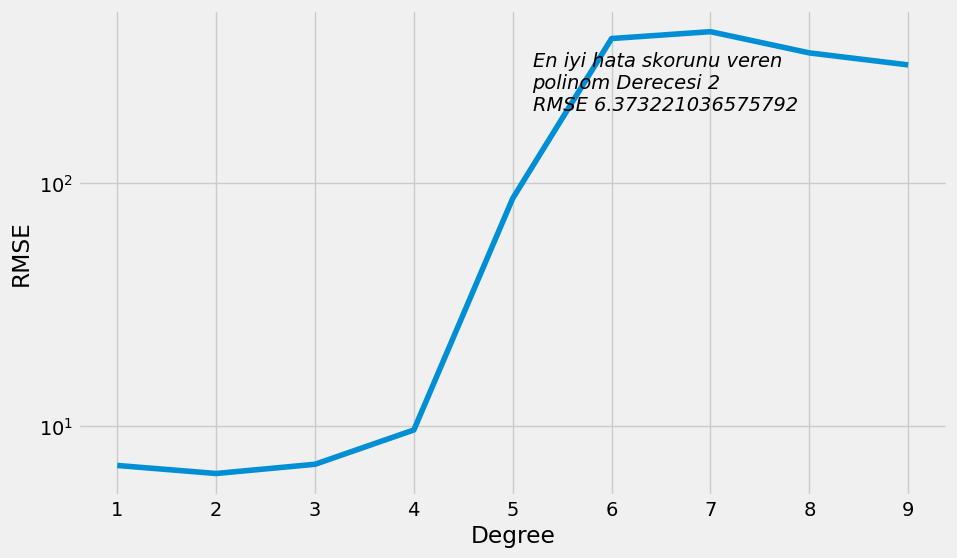

In [13]:
# Belirlediğim tüm polinom dereceleri için rmse skorları grafdiği
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("RMSE")
plt.text(5.2, 200, ("En iyi hata skorunu veren \npolinom Derecesi {} \nRMSE {}".format(min_deg, min_rmse)), style="italic")
bbox = {"facecolor":"orange", "alpha":0.4, "pad":10}

In [14]:
# Uygun polinom derecesine göre modeli oluşturuyorum.
polinom_dercesi = PolynomialFeatures(degree=2)
X_train_polinom = polinom_dercesi.fit_transform(X_train) 
X_test_polinom = polinom_dercesi.fit_transform(X_test)

In [15]:
# Polinom reg algoritmasını eğitiyoruz
model = LinearRegression()
model.fit(X_train_polinom, y_train)

# Çoklu pol. reg. modelinin ön görülen performansları
print("Polinom Reg r2 Eğitim: ", model.score(X_train_polinom, y_train))
print("Polinom Reg r2 Test: ", model.score(X_test_polinom, y_test))

Polinom Reg r2 Eğitim:  0.8488074651060601
Polinom Reg r2 Test:  0.766381462333309


In [16]:
# Tahmin edilen ile gerçek fiyatları görelim.
X_poly = polinom_dercesi.transform(X)

df["Tahmin_ev_fiyatı"] = model.predict(X_poly)
print(df[["Fiyat", "Tahmin_ev_fiyatı",]].head(5))

   Fiyat  Tahmin_ev_fiyatı
0    475        473.924285
1    475        456.574335
2    450        469.501809
3    450        486.973706
4    475        530.482950


In [17]:
# Modele kendimiz bir tahmin yaptıralım.
Oda_sayisi = 4
Net_m2 = 80
Kati = 2
Yasi = 10

ev1 = [[Oda_sayisi, Net_m2, Kati, Yasi]]
ev1_t = polinom_dercesi.transform(ev1)

fiyat = model.predict(ev1_t)

print("Tahmini ev fiyatı:", round(fiyat[0],3), "bin TL")


Tahmini ev fiyatı: 792.062 bin TL


In [18]:
# Oluşturduğumuz modeli ve polinom derecesini kaydediyorum.
import joblib

joblib.dump(model, "model")
joblib.dump(polinom_dercesi, "pol_features")

['pol_features']

--------------------